# Assignment 02: CLIP application

### Basic Imports
---

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import random
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision
from torchvision.datasets import ImageFolder

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

from sklearn.metrics import confusion_matrix, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from torchvision.models import resnet50, ResNet50_Weights

### Hyperparameters
---

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 32
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP
VISUAL_BACKBONES = ['RN50','ViT-B/32', 'ViT-B/16']
class_names = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'normal']

### Device
---

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

### Dataset
---

Load dataset, convert to image storage

In [5]:
test_data_path = 'test.csv'
train_data_path = 'train.csv'
val_data_path = 'val.csv'
test_path = './test'
train_path = './train'
val_path = './val'

In [7]:
# only run once
def make_dir():
    for i in range(0,7):
        p1 = os.path.join(test_path,str(i))
        p2 = os.path.join(train_path,str(i))
        p3 = os.path.join(val_path,str(i))
        if not os.path.exists(p1):
            os.makedirs(p1)
        if not os.path.exists(p2):
            os.makedirs(p2)
        if not os.path.exists(p3):
            os.makedirs(p3) 

def save_images(data_path,dir_path):
    df = pd.read_csv(data_path)
    t_i = [1 for i in range(0,7)]
    for index in range(len(df)):
        emotion = df.loc[index][0]
        image = df.loc[index][1]
        data_array = list(map(float, image.split()))
        data_array = np.asarray(data_array)
        image = data_array.reshape(48, 48)
        im = Image.fromarray(image).convert('L')#8位黑白图片
        t_p = os.path.join(dir_path,str(emotion),'{}.jpg'.format(t_i[emotion]))
        im.save(t_p)
        t_i[emotion] += 1
        #print(t_p)


make_dir()
save_images(test_data_path,test_path)
save_images(train_data_path,train_path)
save_images(val_data_path,val_path)


data distribution

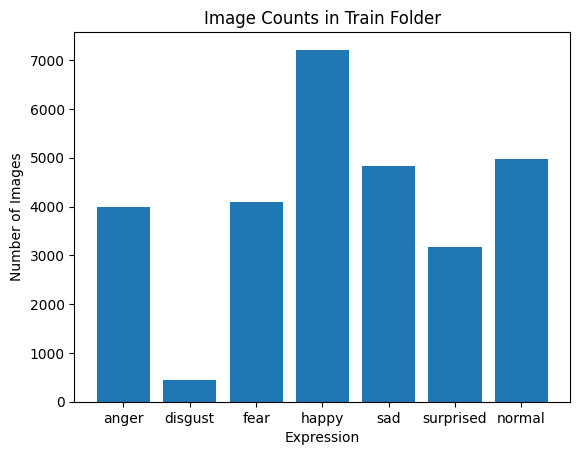

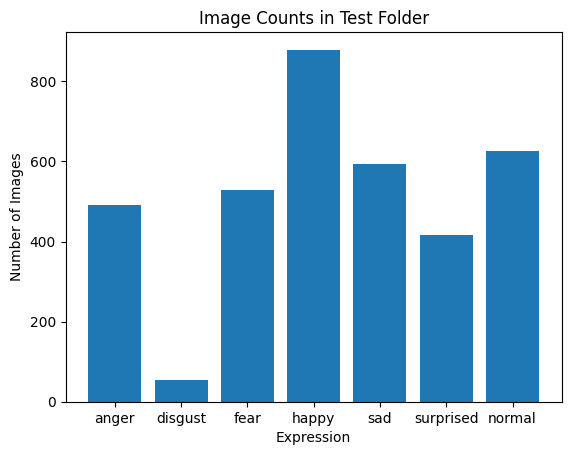

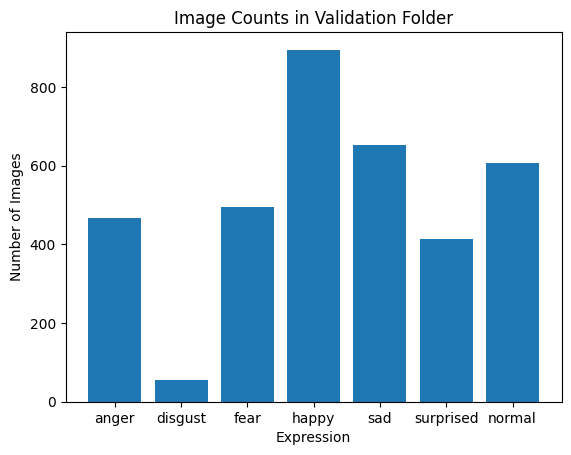

In [8]:
def count_images_in_folder(folder_path):
    counts = []
    for i in range(7):
        subfolder_path = os.path.join(folder_path, str(i))
        if os.path.exists(subfolder_path):
            images = [file for file in os.listdir(subfolder_path) if file.endswith('.jpg')]
            counts.append(len(images))
        else:
            counts.append(0)
    return counts

def plot_histogram(folder_name, counts):
    labels = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprised', 'normal']
    plt.bar(range(7), counts)
    plt.xlabel('Expression')
    plt.ylabel('Number of Images')
    plt.xticks(range(7), labels)
    plt.title(f'Image Counts in {folder_name} Folder')

# train
train_counts = count_images_in_folder('train')
plot_histogram('Train', train_counts)
plt.savefig('result/train_data_count.png')
plt.show()

# test
test_counts = count_images_in_folder('test')
plot_histogram('Test', test_counts)
plt.savefig('result/test_data_count.png')
plt.show()

# val
val_counts = count_images_in_folder('val')
plot_histogram('Validation', val_counts)
plt.savefig('result/val_data_count.png')
plt.show()

In [6]:
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_set = torchvision.datasets.ImageFolder(root=test_path,transform=transforms_test)
test_dataloader = torch.utils.data.DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False)

### Model
---

In [7]:
# Load the model:backbone=rn50
model_rn50, preprocess_rn50 = clip.load(name=VISUAL_BACKBONES[0], device=device, download_root='/shareddata/clip/')
model_rn50.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [8]:
# Load the model:backbone=vit-b/32
model_v32, preprocess_v32 = clip.load(name=VISUAL_BACKBONES[1], device=device, download_root='/shareddata/clip/')
model_v32.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [9]:
# Load the model:backbone=vit-b/16
model_v16, preprocess_v16 = clip.load(name=VISUAL_BACKBONES[2], device=device, download_root='/shareddata/clip/')
model_v16.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### CLIP Preparation
---

#### 1. Using CLIP text to encoder encode the text 

In [10]:
def prompt_encode(prompt_1,prompt_2):
    """
    Args:
        prompt (str): the text prefix before the class

    Returns:
        text_inputs(torch.Tensor)

    """
    text_inputs = torch.cat([clip.tokenize(f"{prompt_1} {c} {prompt_2}") for c in class_names]).to(device)
    
    return text_inputs


#### 2. Zero-shot inference

In [11]:
def model_inference(model, image, text_inputs):

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    logits = (100.0 * image_features @ text_features.T)

    return logits

#### 3. Zero-shot accuracy calculation

In [12]:
def zero_shot_test(test_model,prompt_1,prompt_2):
    with torch.no_grad():
        test_model.eval()

        val_corrects = 0
        num = 0
        all_targets = []
        all_predictions = []
        
        for batch_idx, (image, target) in enumerate(test_dataloader):
                num += 1
                image = image.to(device)
                target = target.to(device)
                text_inputs = prompt_encode(prompt_1,prompt_2)

                # test model
                logits = model_inference(test_model, image, text_inputs)
                values, indices = torch.max(logits, 1)

                val_corrects += torch.sum(indices == target.data).item()
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(indices.cpu().numpy())
                

        val_acc = val_corrects / len(test_set)
        conf_matrix = confusion_matrix(all_targets, all_predictions)
        # Calculate UAR
        recalls = recall_score(all_targets, all_predictions, average=None)
        uar = np.mean(recalls)

        print(f"the zero-shot accuracy on FER2013 is {val_acc*100:.2f}%, uar is {uar:.4f}")
        return conf_matrix, val_acc, uar

In [14]:
def plot_conf_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Zero shot Transfer
---

#### 1.0 prompt and run

In [13]:
default_prompt_1 = 'a photo of'
default_prompt_2 = ''
v_prompt_1 = 'a photo of'
v_prompt_2 = ', a type of facial expression'
w_prompt_1 = 'a facial expression depicting'
w_prompt_2 = ''
base_prompt_1 = ''
base_prompt_2 = ''

##### default prompt

In [16]:
conf_matrix_d_rn,acc_d_rn,uar_d_rn = zero_shot_test(model_rn50,default_prompt_1,default_prompt_2)
conf_matrix_d_v32,acc_d_v32,uar_d_v32 = zero_shot_test(model_v32,default_prompt_1,default_prompt_2)
conf_matrix_d_v16,acc_d_v16,uar_d_v16 = zero_shot_test(model_v16,default_prompt_1,default_prompt_2)

the zero-shot accuracy on FER2013 is 39.90%, uar is 0.3204
the zero-shot accuracy on FER2013 is 37.78%, uar is 0.3601
the zero-shot accuracy on FER2013 is 39.98%, uar is 0.3645


##### change prompt v1

In [17]:
conf_matrix_v_rn,acc_v_rn,uar_v_rn = zero_shot_test(model_rn50,v_prompt_1,v_prompt_2)
conf_matrix_v_v32,acc_v_v32,uar_v_v32 = zero_shot_test(model_v32,v_prompt_1,v_prompt_2)
conf_matrix_v_v16,acc_v_v16,uar_v_v16 = zero_shot_test(model_v16,v_prompt_1,v_prompt_2)

the zero-shot accuracy on FER2013 is 39.82%, uar is 0.3106
the zero-shot accuracy on FER2013 is 39.34%, uar is 0.3464
the zero-shot accuracy on FER2013 is 47.26%, uar is 0.3951


##### change prompt v2

In [14]:
conf_matrix_w_rn,acc_w_rn,uar_w_rn = zero_shot_test(model_rn50,w_prompt_1,w_prompt_2)
conf_matrix_w_v32,acc_w_v32,uar_w_v32 = zero_shot_test(model_v32,w_prompt_1,w_prompt_2)
conf_matrix_w_v16,acc_w_v16,uar_w_v16 = zero_shot_test(model_v16,w_prompt_1,w_prompt_2)

the zero-shot accuracy on FER2013 is 37.28%, uar is 0.2839
the zero-shot accuracy on FER2013 is 44.13%, uar is 0.3672
the zero-shot accuracy on FER2013 is 48.04%, uar is 0.3888


##### contextless class name

In [19]:
conf_matrix_b_rn,acc_b_rn,uar_b_rn = zero_shot_test(model_rn50,base_prompt_1,base_prompt_2)
conf_matrix_b_v32,acc_b_v32,uar_b_v32 = zero_shot_test(model_v32,base_prompt_1,base_prompt_2)
conf_matrix_b_v16,acc_b_v16,uar_b_v16 = zero_shot_test(model_v16,base_prompt_1,base_prompt_2)

the zero-shot accuracy on FER2013 is 33.83%, uar is 0.2642
the zero-shot accuracy on FER2013 is 35.02%, uar is 0.3453
the zero-shot accuracy on FER2013 is 40.35%, uar is 0.3665


#### 1.1 accuracy_compare

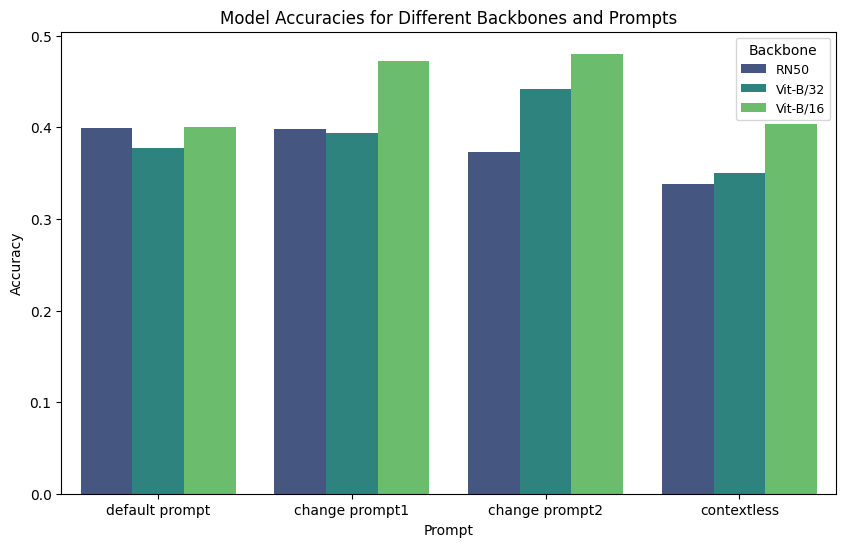

In [20]:
data = {
    'Backbone': ['RN50', 'RN50', 'RN50', 'RN50', 'Vit-B/32', 'Vit-B/32', 'Vit-B/32','Vit-B/32', 'Vit-B/16', 'Vit-B/16', 'Vit-B/16','Vit-B/16'],
    'Prompt': ['default prompt', 'change prompt1', 'change prompt2', 'contextless'] * 3,
    'Accuracy': [acc_d_rn,acc_v_rn,acc_w_rn,acc_b_rn,acc_d_v32,acc_v_v32,acc_w_v32,acc_b_v32,acc_d_v16
                ,acc_v_v16,acc_w_v16,acc_b_v16],
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', n_colors=len(df['Backbone'].unique()))
ax = sns.barplot(data=df, x='Prompt', y='Accuracy', hue='Backbone', palette=palette)

plt.title('Model Accuracies for Different Backbones and Prompts')
plt.xlabel('Prompt')
plt.ylabel('Accuracy')
plt.legend(title='Backbone', loc='upper right', prop={'size': 9})

plt.savefig('result/zs_acc_compare.jpg')
plt.show()

#### 1.2 confusion matrix

Confusion Matrix Plots For 4 Prompts with Backbone ViT-B/16

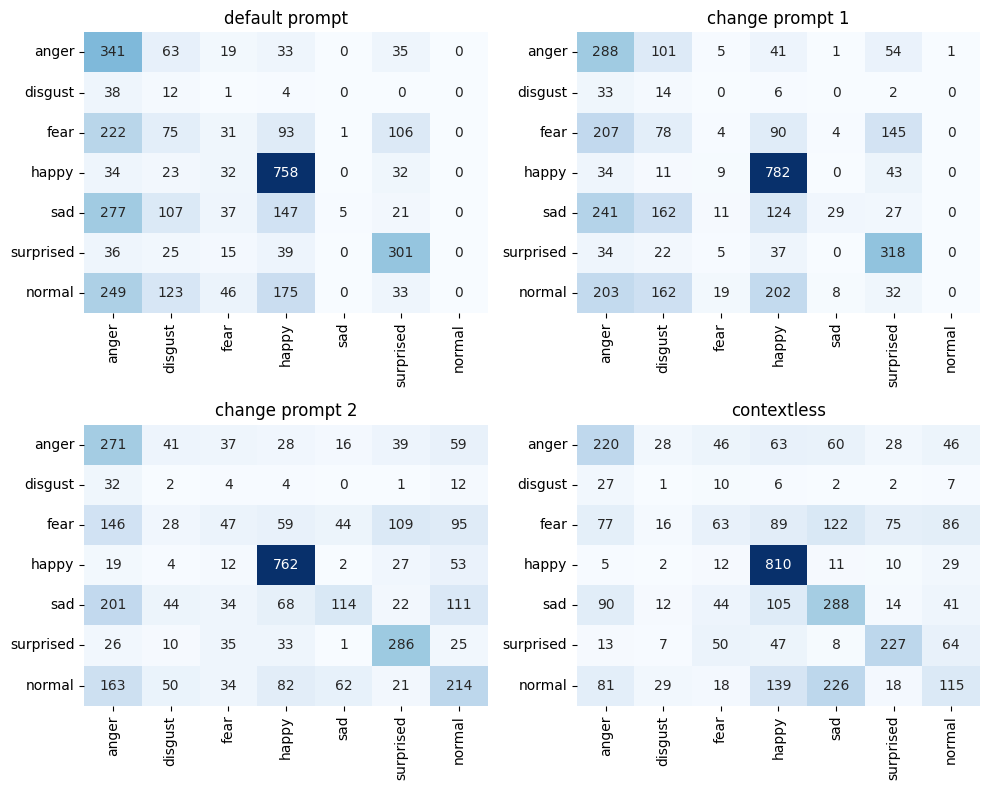

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(conf_matrix_d_v16, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names,ax=axes[0, 1])
axes[0, 0].set_title('default prompt')

sns.heatmap(conf_matrix_v_v16, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names,ax=axes[1, 0])
axes[0, 1].set_title('change prompt 1')

sns.heatmap(conf_matrix_w_v16, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names, ax=axes[1, 1])
axes[1, 0].set_title('change prompt 2')

sns.heatmap(conf_matrix_b_v16, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[1, 1].set_title('contextless')

plt.tight_layout()
plt.savefig('result/zs_cm_compare.jpg')
plt.show()

#### 1.3 uar_compare

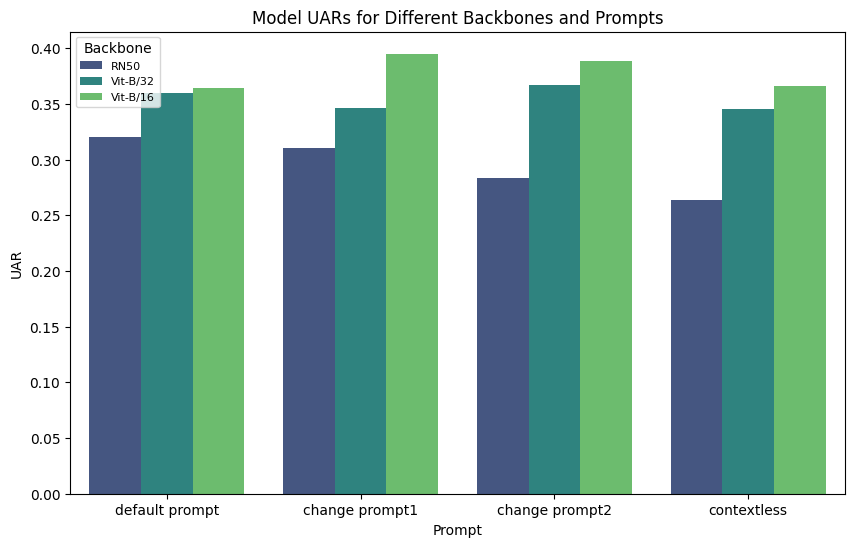

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Backbone': ['RN50', 'RN50', 'RN50', 'RN50', 'Vit-B/32', 'Vit-B/32', 'Vit-B/32','Vit-B/32', 'Vit-B/16', 'Vit-B/16', 'Vit-B/16','Vit-B/16'],
    'Prompt': ['default prompt', 'change prompt1', 'change prompt2', 'contextless'] * 3,
    'UAR': [uar_d_rn,uar_v_rn,uar_w_rn,uar_b_rn,uar_d_v32,uar_v_v32,uar_w_v32,uar_b_v32,uar_d_v16
                ,uar_v_v16,uar_w_v16,uar_b_v16],
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', n_colors=len(df['Backbone'].unique()))
ax = sns.barplot(data=df, x='Prompt', y='UAR', hue='Backbone', palette=palette)

plt.title('Model UARs for Different Backbones and Prompts')
plt.xlabel('Prompt')
plt.ylabel('UAR')
plt.legend(title='Backbone', loc='upper left', prop={'size': 8})

plt.savefig('result/zs_uar_compare.jpg')
plt.show()

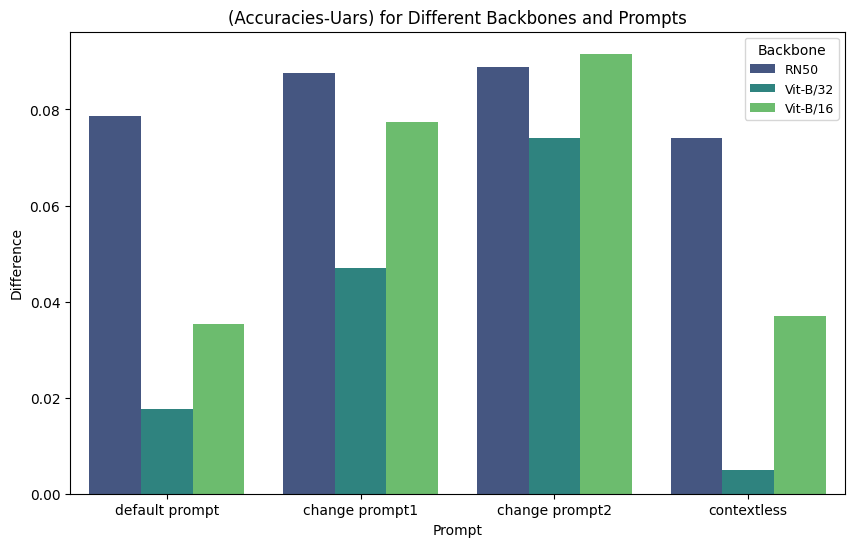

In [24]:
data = {
    'Backbone': ['RN50', 'RN50', 'RN50', 'RN50', 'Vit-B/32', 'Vit-B/32', 'Vit-B/32','Vit-B/32', 'Vit-B/16', 'Vit-B/16', 'Vit-B/16','Vit-B/16'],
    'Prompt': ['default prompt', 'change prompt1', 'change prompt2', 'contextless'] * 3,
    'Difference': [acc_d_rn-uar_d_rn,acc_v_rn-uar_v_rn,acc_w_rn-uar_w_rn,acc_b_rn-uar_b_rn,
                   acc_d_v32-uar_d_v32,acc_v_v32-uar_v_v32,acc_w_v32-uar_w_v32,acc_b_v32-uar_b_v32,
                   acc_d_v16-uar_d_v16,acc_v_v16-uar_v_v16,acc_w_v16-uar_w_v16,acc_b_v16-uar_b_v16],
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', n_colors=len(df['Backbone'].unique()))
ax = sns.barplot(data=df, x='Prompt', y='Difference', hue='Backbone', palette=palette)

plt.title('(Accuracies-Uars) for Different Backbones and Prompts')
plt.xlabel('Prompt')
plt.ylabel('Difference')
plt.legend(title='Backbone', loc='upper right', prop={'size': 9})

plt.savefig('result/zs_df_compare.jpg')
plt.show()

#### 1.4 compare with zero-shot baseline model

In [39]:
def random_baseline_test(test_dataloader):
    accs = []
    uars = []
    for i in range(10):
        all_targets = []
        all_predictions = []
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):
            target = target.numpy()  # Convert target tensor to numpy array

            # Generate random predictions
            random_predictions = np.random.randint(0, 7, size=len(target))
            val_corrects += np.sum(random_predictions == target.data).item()

            all_targets.extend(target)
            all_predictions.extend(random_predictions)

        val_acc = val_corrects / len(test_set)
        recalls = recall_score(all_targets, all_predictions, average=None)
        uar = np.mean(recalls)
        accs.append(val_acc)
        uars.append(uar)
        
    print(f"acc:{sum(accs)*100/10:.2f}%")
    print(f"uar:{sum(uars)*100/10:.2f}%")

random_baseline_test(test_dataloader)

acc:14.03%
uar:14.28%


In [37]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_fer_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_fer_classes)

model = model.to(device)
model.eval()

class_correct = [0] * num_fer_classes
class_total = [0] * num_fer_classes

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        for i in range(num_fer_classes):
            class_correct[i] += ((predictions == labels) & (labels == i)).sum().item()
            class_total[i] += (labels == i).sum().item()

accuracy = sum(class_correct) / sum(class_total)
print(f'acc:{accuracy * 100:.2f}%')

recalls = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(num_fer_classes)]
uar = sum(recalls) / num_fer_classes
print(f'uar:{uar * 100:.2f}%')

acc:21.26%
uar:13.70%


### Few shot Learning
---

#### dataset

In [15]:
def dataset_prepare(shot_folder, images_per_class):
    if not os.path.exists(shot_folder):
        os.makedirs(shot_folder)

    for class_folder in os.listdir(base_folder):
        class_folder_path = os.path.join(base_folder, class_folder)

        if os.path.isdir(class_folder_path):
            image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                # Create a folder for each class in num_shot_folder
                class_shot_folder = os.path.join(shot_folder, class_folder)
                os.makedirs(class_shot_folder, exist_ok=True)

                # Randomly choose images from the current class
                selected_images = random.sample(image_files, images_per_class)

                # Copy selected images to the num-shot folder
                for selected_image in selected_images:
                    source_path = os.path.join(class_folder_path, selected_image)
                    destination_path = os.path.join(class_shot_folder, f"{selected_image}")
                    shutil.copy(source_path, destination_path)

    print(f"{images_per_class}-shot dataset created successfully.")

#### finetune and test

In [16]:
def get_features(data_loader):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            features = model_v16.encode_image(images)

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [32]:
def few_shot(train_dataloader):
    train_features, train_labels = get_features(train_dataloader)
    test_features, test_labels = get_features(test_dataloader)

    classifier = LogisticRegression(random_state=0, C=0.2, max_iter=500, verbose=0, solver='lbfgs')
    classifier.fit(train_features, train_labels)

    predictions = classifier.predict(test_features)
    accuracy = np.mean((test_labels == predictions).astype(float))
    
    report = classification_report(test_labels, predictions, output_dict=True)
    uar = np.mean([report[str(i)]['recall'] for i in range(len(report) - 3)])
    
    print(f"Accuracy = {accuracy:.3f}")
    print(f'UAR = {uar:.3f}')
    return accuracy,uar

In [18]:
base_folder = 'train'

#### one shot

In [19]:
shot_folder = 'one_shot_dataset'
images_per_class = 1
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [20]:
one_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
one_shot_dataloader = torch.utils.data.DataLoader(dataset=one_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
acc_1,uar_1 = few_shot(one_shot_dataloader) 

Accuracy = 0.190
UAR = 0.218


#### few shot-2

In [34]:
shot_folder = '2_shot_dataset'
images_per_class = 2
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [35]:
v2_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v2_shot_dataloader = torch.utils.data.DataLoader(dataset=v2_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [53]:
acc_2,uar_2 = few_shot(v2_shot_dataloader)

Accuracy = 0.272
UAR = 0.253


#### few shot-4

In [37]:
shot_folder = '4_shot_dataset'
images_per_class = 4
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [38]:
v4_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v4_shot_dataloader = torch.utils.data.DataLoader(dataset=v4_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [54]:
acc_4,uar_4 = few_shot(v4_shot_dataloader)

Accuracy = 0.287
UAR = 0.318


#### few shot-8

In [40]:
shot_folder = '8_shot_dataset'
images_per_class = 8
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [41]:
v8_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v8_shot_dataloader = torch.utils.data.DataLoader(dataset=v8_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [55]:
acc_8,uar_8 = few_shot(v8_shot_dataloader)

Accuracy = 0.334
UAR = 0.354


#### few shot-16

In [43]:
shot_folder = '16_shot_dataset'
images_per_class = 16
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [44]:
v16_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v16_shot_dataloader = torch.utils.data.DataLoader(dataset=v16_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [56]:
acc_16,uar_16 = few_shot(v16_shot_dataloader)

Accuracy = 0.432
UAR = 0.426


#### few shot-32

In [46]:
shot_folder = '32_shot_dataset'
images_per_class = 32
if not os.path.exists(shot_folder):
    dataset_prepare(shot_folder, images_per_class)

In [47]:
v32_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v32_shot_dataloader = torch.utils.data.DataLoader(dataset=v32_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [57]:
acc_32,uar_32 = few_shot(v32_shot_dataloader)

Accuracy = 0.464
UAR = 0.463


#### few shot-40

In [49]:
shot_folder = '40_shot_dataset'
images_per_class = 40
dataset_prepare(shot_folder, images_per_class)

40-shot dataset created successfully.


In [50]:
v40_shot_set = torchvision.datasets.ImageFolder(root=shot_folder,transform=transforms_test)
v40_shot_dataloader = torch.utils.data.DataLoader(dataset=v40_shot_set,batch_size=BATCH_SIZE,shuffle=False)

In [58]:
acc_40,uar_40 = few_shot(v40_shot_dataloader)

Accuracy = 0.520
UAR = 0.494


#### analysis

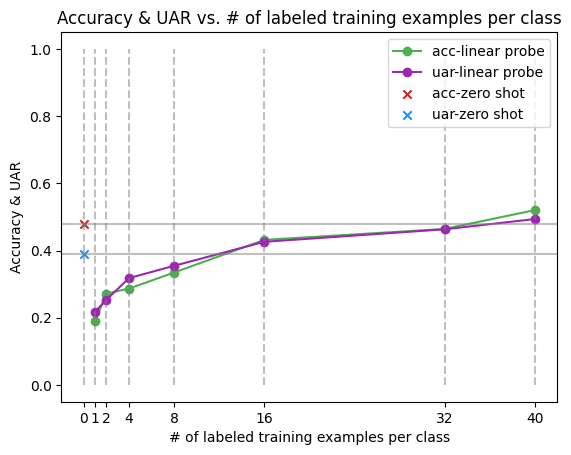

In [63]:
accs = [acc_w_v16, acc_1, acc_2, acc_4, acc_8, acc_16, acc_32, acc_40]
uars = [uar_w_v16, uar_1, uar_2, uar_4, uar_8, uar_16, uar_32, uar_40]

training_examples = [0, 1, 2, 4, 8, 16, 32, 40]

plt.plot(training_examples[1:], accs[1:], marker='o', linestyle='-', color='#4CAF50', label='acc-linear probe')
plt.plot(training_examples[1:], uars[1:], marker='o', linestyle='-', color='#9C27B0', label='uar-linear probe')

plt.scatter(training_examples[0], accs[0], marker='x', color='#CD2626', label='acc-zero shot')
plt.scatter(training_examples[0], uars[0], marker='x', color='#1E90FF', label='uar-zero shot')

plt.title('Accuracy & UAR vs. # of labeled training examples per class')
plt.xlabel('# of labeled training examples per class')
plt.ylabel('Accuracy & UAR')

plt.xticks(training_examples)

for point in training_examples:
    plt.vlines(x=point, ymin=0, ymax=1, color='gray', linestyle='--', alpha=0.5)

plt.axhline(y=accs[0], color='gray', linestyle='-', alpha=0.5)  
plt.axhline(y=uars[0], color='gray', linestyle='-', alpha=0.5)  

plt.legend()

plt.savefig('result/0_linear_probe.jpg',dpi=600)
plt.show()
